### Create the right environment for Feel ++


In [1]:
import os
import sys
import feelpp
import feelpp.toolboxes.core as tb

from tools.GmeshRead import mesh2d
from tools.cmap import custom_cmap
import pandas as pd
import numpy as np
import pyvista as pv

import plotly.express as px
from plotly.subplots import make_subplots
import itertools
import torch
from pathlib import Path
from tools.Poisson_feelpp import Poisson_feel

# mandatory things
sys.argv = ["feelpp_app"]
e = feelpp.Environment(sys.argv,
                       opts=tb.toolboxes_options("coefficient-form-pdes", "cfpdes"),
                       config=feelpp.localRepository('feelpp_cfpde'))

# ------------------------------------------------------------------------- #
# Poisson problem
# - div (diff * grad (u)) = f    in Omega
#                     u   = g    in Gamma_D
# Omega = domain, either cube or ball
# Approx = lagrange Pk of order order
# mesh of size h



[ Starting Feel++ ] application feelpp_app version 0.1 date 2024-Jun-07
 . feelpp_app files are stored in /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1
 .. logfiles :/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/logs


### Function for extracting solution array

In [2]:
def extract_solution(file_path):
    # Fichier .case
    #file_path = '/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/cfpdes-2d-p1.exports/Export.case'
    data = pv.read(file_path)

    # Extraire les données de chaque bloc
    for i, block in enumerate(data):
        if block is None:
            continue
        
        print("Champs de points disponibles:", block.point_data.keys())
        print("Champs de cellules disponibles:", block.cell_data.keys())

        solution = block.point_data['cfpdes.poisson.u']
        print("Valeurs de 'cfpdes.poisson.u':")
        print(solution) 


        df = pd.DataFrame(block.point_data)
        print(df.head())
    return solution

### Function for comparing the computed solution with the extracted solution  

In [3]:


from xvfbwrapper import Xvfb
import pyvista as pv 
import matplotlib.pyplot as plt

def myplots(P, solution, dim=2, field="cfpdes.poisson.u", factor=1, cmap=custom_cmap):
    reader = pv.get_reader(f"cfpdes-{P.dim}d-p{P.order}.exports/Export.case")
    mesh = reader.read()
    #pv_plot(mesh, field)
    pl = pv.Plotter(shape=(1,2))

    pl.add_title(f'Solution P{P.order}', font_size=18)
    pl.add_mesh(mesh[0], scalars = "cfpdes.poisson.u", cmap=custom_cmap)

    pl.subplot(0,1)
    pl.add_title('u_extracted ' , font_size=10)
    pl.add_mesh(mesh[0].copy(), scalars = solution , cmap=custom_cmap)

    
    pl.link_views()
    pl.view_xy()
    pl.show()
    #pl.screenshot(plot)

### Reading mesh nodes

In [4]:
def read_nodes(mesh, verbose = True):
    my_mesh = mesh2d(mesh)
    my_mesh.read_mesh()
    coordinates = my_mesh.Nodes
    if verbose :
        print('\nnumber of nodes = ', my_mesh.Nnodes)
        for i in range(my_mesh.Nnodes):
            print(f'\n x_{i} , y_{i} = ', coordinates[i])
    return my_mesh, coordinates

# Reading nodes for square mesh
#mesh = '/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.msh'
#read_nodes(mesh)

### Solving the Laplacian problem on the default square domain

In [5]:
# Solving 
P = Poisson_feel(dim = 2)
u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'
h = 0.05


In [6]:

P(h=h, rhs=rhs, g='0', u_exact = u_exact)
print("\nmeasures = ", P.measures)


[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                               |
| | Environment                                                                          |                                                            

In [7]:

# Extracting the solution
file_path = f"cfpdes-{P.dim}d-p{P.order}.exports/Export.case"
poisson_u = extract_solution(file_path)

# Reading mesh nodes
mesh = '/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.msh'
my_mesh, coordinates = read_nodes(mesh, verbose = False)

print('\nlength u = ', len(poisson_u),' number of nodes = ', my_mesh.Nnodes)
for i in range(my_mesh.Nnodes):
    print(f'\n u({coordinates[i]}) = ', poisson_u[i] )


Champs de points disponibles: ['cfpdes.expr.grad_u_exact', 'cfpdes.expr.rhs', 'cfpdes.expr.u_exact', 'cfpdes.poisson.u']
Champs de cellules disponibles: ['cfpdes.pid']
Valeurs de 'cfpdes.poisson.u':
[-2.55882740e-01 -5.23014128e-01 -5.31600416e-01  4.51528639e-01
  5.54935336e-01  2.73693860e-01  0.00000000e+00  2.99670160e-01
  2.41641000e-01 -2.30834827e-01 -2.98673511e-01  0.00000000e+00
 -5.33562183e-01 -2.16567665e-01 -2.62957275e-01 -2.98950762e-01
 -1.16792865e-01 -1.96071774e-01  2.09492356e-01 -2.40673989e-01
 -5.17238796e-01 -2.29681395e-02 -1.59088224e-01 -2.30080426e-01
  1.77676231e-02  7.04201043e-01  4.76363331e-01  4.27088797e-01
 -3.99901003e-01  6.02511168e-01 -1.92533553e-01 -3.79127443e-01
  2.35925078e-01  1.21274188e-01  1.42786294e-01  3.49430382e-01
  1.98928967e-01  2.72179306e-01  5.43170035e-01  3.07718098e-01
  4.96022046e-01  2.44866043e-01 -3.00625324e-01 -1.20702796e-01
  2.44207501e-01  5.30696392e-01 -2.99294651e-01 -3.27872336e-01
 -1.33652657e-01  4.9

### Comparing solution extracted and solution computed

Champs de points disponibles: ['cfpdes.expr.grad_u_exact', 'cfpdes.expr.rhs', 'cfpdes.expr.u_exact', 'cfpdes.poisson.u']
Champs de cellules disponibles: ['cfpdes.pid']
Valeurs de 'cfpdes.poisson.u':
[-2.55882740e-01 -5.23014128e-01 -5.31600416e-01  4.51528639e-01
  5.54935336e-01  2.73693860e-01  0.00000000e+00  2.99670160e-01
  2.41641000e-01 -2.30834827e-01 -2.98673511e-01  0.00000000e+00
 -5.33562183e-01 -2.16567665e-01 -2.62957275e-01 -2.98950762e-01
 -1.16792865e-01 -1.96071774e-01  2.09492356e-01 -2.40673989e-01
 -5.17238796e-01 -2.29681395e-02 -1.59088224e-01 -2.30080426e-01
  1.77676231e-02  7.04201043e-01  4.76363331e-01  4.27088797e-01
 -3.99901003e-01  6.02511168e-01 -1.92533553e-01 -3.79127443e-01
  2.35925078e-01  1.21274188e-01  1.42786294e-01  3.49430382e-01
  1.98928967e-01  2.72179306e-01  5.43170035e-01  3.07718098e-01
  4.96022046e-01  2.44866043e-01 -3.00625324e-01 -1.20702796e-01
  2.44207501e-01  5.30696392e-01 -2.99294651e-01 -3.27872336e-01
 -1.33652657e-01  4.9

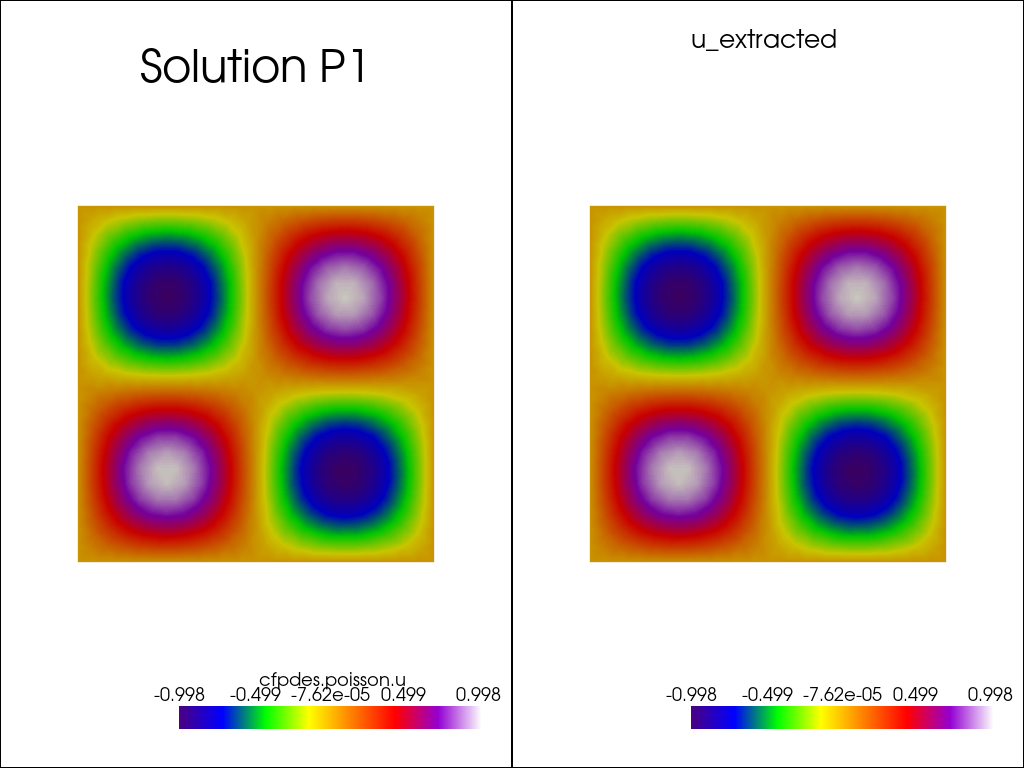

In [8]:

file_path = f"cfpdes-{P.dim}d-p{P.order}.exports/Export.case"
poisson_u = extract_solution(file_path)

vdisplay = Xvfb()
vdisplay.start()
pv.set_jupyter_backend('static') 

solution = poisson_u
myplots(P, solution, dim=2,factor= 1)

### Doing the same for a disk domain

In [9]:
# for disk domain
u_exact =  'sin(pi*(x*x + y*y))'
rhs = '4* pi * (-cos(pi* (x*x + y*y)) + pi * (x*x + y*y)* sin(pi* (x*x + y*y)))'
P(rhs=rhs, g='sin(pi*(x*x + y*y))', geofile='/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/disk.geo', u_exact = u_exact)
print("\nmeasures = ", P.measures)

# Extracting the solution
file_path = f"cfpdes-{P.dim}d-p{P.order}.exports/Export.case"
poisson_u = extract_solution(file_path)

# Reading mesh nodes
mesh = '/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/disk.msh'
my_mesh, coordinates = read_nodes(mesh, verbose = False)

for i in range(my_mesh.Nnodes-2):
    print(f'\n u({coordinates[i]}) = ', poisson_u[i] )

print('\nlength u = ', len(poisson_u),' number of nodes = ', my_mesh.Nnodes)




[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/disk.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/disk.geo 0.05 
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                                           |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                                                         |
| | Environment                                     

In [10]:
u_exact = 'y + (x*(1-x) + y*(1-y)/4) '
P(rhs='5/2', g='y', u_exact = u_exact)

u_exact = '-y*y/2 - x*y*y*y/2 + y*y*y*y/4'

P( rhs='-1.0-3*y*x+y*y', g='-y*y/2 - x*y*y*y/2 + y*y*y*y/4', u_exact = u_exact)
print("\nmeasures = ", P.measures)

# Extracting the solution
file_path = f"cfpdes-{P.dim}d-p{P.order}.exports/Export.case"
poisson_u = extract_solution(file_path)

# Reading mesh nodes
mesh = '/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.msh'
my_mesh, coordinates = read_nodes(mesh, verbose = False)

for i in range(my_mesh.Nnodes-2):
    print(f'\n u({coordinates[i]}) = ', poisson_u[i] )

print('\nlength u = ', len(poisson_u),' number of nodes = ', my_mesh.Nnodes)

[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                             |
+------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                           |
| | Environment                                                                          |                                           |
| +--------------------------------------------------------------------------------------+     

In [11]:


# # 2D with varying anisotropy

u_exact = 'x*x/(1+x) + y*y/(1+y)'
P(rhs='4', diff='{1+x,0,0,1+y}', g='x*x/(1+x) + y*y/(1+y)', u_exact = u_exact)

P(rhs='4', diff='{x,y,-y,x+y}', g='x*x/(1+x) + y*y/(1+y)', u_exact = u_exact)



[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+---------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                |
+---------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                              |
| | Environment                                                                          |                                              |
| +-----------------------------------------------------------------------------

In [12]:
"""
P = Poisson_feel(dim = 3)
P(diff='{1,0,0,0,x+1,0,0,0,1+x*y}', g = 'x', rhs='x*y*z', geofile = 'geo/cube.geo', plot='3d.png')
"""

"\nP = Poisson_feel(dim = 3)\nP(diff='{1,0,0,0,x+1,0,0,0,1+x*y}', g = 'x', rhs='x*y*z', geofile = 'geo/cube.geo', plot='3d.png')\n"

### Computing error convergence rates

In [13]:
"""
def runLaplacianPk(P, df, model, fn = f'omega-{P.dim}.geo', verbose=False):
    #Generate the Pk case
    meas = dict()
    dim, order, json = model
    #for h in df['h']:
    m = P.measures   
    print('m = ', m)
    print('keys = ', m.keys())
    for norm in ['L2', 'H1']:      
      meas.setdefault(f'P{order}-Norm_poisson_{norm}-error', [])
      meas[f'P{order}-Norm_poisson_{norm}-error'].append(m.pop(f'Norm_poisson_{norm}-error'))
    df = df.assign(**meas)
    for norm in ['L2', 'H1']:
      df[f'P{order}-poisson_{norm}-convergence-rate']=np.log2(df[f'P{order}-Norm_poisson_{norm}-error'].shift() / df[f'P{order}-Norm_poisson_{norm}-error']) / np.log2(df['h'].shift() / df['h'])
    return df


def runConvergenceAnalysis(P, json,dim=2,hs=[0.1,0.05,0.025,0.0125],orders=[1,2],verbose=False):
  df=pd.DataFrame({'h':hs})
  for order in orders:
    df=runLaplacianPk(P, df=df,model=[dim,order,json(dim=dim,order=order)],fn = f'omega-{P.dim}.geo', verbose=verbose)
  print('df = ', df.to_markdown())
  return df

def plot_convergence(P, df,dim,orders=[1,2]):
  fig=px.line(df, x="h", y=[f'P{order}-Norm_poisson_{norm}-error' for order,norm in list(itertools.product(orders,['L2','H1']))])
  fig.update_xaxes(title_text="h",type="log")
  fig.update_yaxes(title_text="Error",type="log")
  for order,norm in list(itertools.product(orders,['L2','H1'])):
    fig.update_traces(name=f'P{order} - {norm} error - {df[f"P{order}-poisson_{norm}-convergence-rate"].iloc[-1]:.2f}', selector=dict(name=f'P{order}-Norm_poisson_{norm}-error'))
  fig.update_layout(
          title=f"Convergence rate for the {dim}D Poisson problem",
          autosize=False,
          width=900,
          height=900,
      )
  return fig

u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

P(rhs=rhs, g='0', plot=None, u_exact = u_exact)
fn = f'omega-{P.dim}.geo'
hs=[0.1,0.05,0.025,0.0125]
P.measures = P.feel_solver(filename=fn, h=hs[0], dim=P.dim, verbose=False)
poisson_json = lambda order,dim=2,name="u": P.model
json=poisson_json
print('measures = ', P.measures)
model=[P.dim,P.order,json(dim=P.dim,order=P.order)]
print('model =', model)

df= runConvergenceAnalysis(P, json=json,dim=2,verbose=False)
fig= plot_convergence(P, df,dim=2)
fig.show()
"""
  

'\ndef runLaplacianPk(P, df, model, fn = f\'omega-{P.dim}.geo\', verbose=False):\n    #Generate the Pk case\n    meas = dict()\n    dim, order, json = model\n    #for h in df[\'h\']:\n    m = P.measures   \n    print(\'m = \', m)\n    print(\'keys = \', m.keys())\n    for norm in [\'L2\', \'H1\']:      \n      meas.setdefault(f\'P{order}-Norm_poisson_{norm}-error\', [])\n      meas[f\'P{order}-Norm_poisson_{norm}-error\'].append(m.pop(f\'Norm_poisson_{norm}-error\'))\n    df = df.assign(**meas)\n    for norm in [\'L2\', \'H1\']:\n      df[f\'P{order}-poisson_{norm}-convergence-rate\']=np.log2(df[f\'P{order}-Norm_poisson_{norm}-error\'].shift() / df[f\'P{order}-Norm_poisson_{norm}-error\']) / np.log2(df[\'h\'].shift() / df[\'h\'])\n    return df\n\n\ndef runConvergenceAnalysis(P, json,dim=2,hs=[0.1,0.05,0.025,0.0125],orders=[1,2],verbose=False):\n  df=pd.DataFrame({\'h\':hs})\n  for order in orders:\n    df=runLaplacianPk(P, df=df,model=[dim,order,json(dim=dim,order=order)],fn = f\'omeg